# Complete Input-to-Output Flow in BERT

This notebook traces a complete journey from raw text to final predictions in Mini-BERT.

## What You'll Learn:
1. Text â†’ Tokens â†’ IDs (Tokenization)
2. IDs â†’ Embeddings (Input representation)
3. Embeddings â†’ Hidden states (Transformer processing)
4. Hidden states â†’ Logits (Output projection)
5. Logits â†’ Predictions (Final processing)
6. Shape transformations at each step

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from model import MiniBERT
from tokenizer import WordPieceTokenizer
from mlm import mask_tokens

np.random.seed(42)
# Set style for better visualizations - handle version compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')


## Part 1: From Raw Text to Token IDs

The first step is converting human-readable text into numbers the model can process.

In [ ]:
# Load tokenizer
tokenizer = WordPieceTokenizer()
tokenizer.load_model('../tokenizer_8k.pkl')

# Example text
raw_text = "The quick brown fox jumps over the lazy dog."
print(f"Raw text: '{raw_text}'")
print(f"Length: {len(raw_text)} characters")

# Step 1: Tokenization
token_ids = tokenizer.encode(raw_text)
tokens = []
for tid in token_ids:
    if hasattr(tokenizer, 'id_to_token') and tid in tokenizer.id_to_token:
        tokens.append(tokenizer.id_to_token[tid])
    elif hasattr(tokenizer, 'vocab'):
        # Create reverse vocab mapping
        inv_vocab = {v: k for k, v in tokenizer.vocab.items()}
        tokens.append(inv_vocab.get(tid, f'ID_{tid}'))
    else:
        tokens.append(f'ID_{tid}')

print(f"\nAfter tokenization:")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of tokens: {len(token_ids)}")

# Visualize token mapping
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(tokens)), [len(str(token)) for token in tokens], color='skyblue')
plt.xticks(range(len(tokens)), [str(t)[:8] for t in tokens], rotation=45, ha='right')
plt.ylabel('Token Length (chars)')
plt.title('Token Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(len(token_ids)), token_ids, color='lightcoral')
plt.xticks(range(len(token_ids)), [str(t)[:8] for t in tokens], rotation=45, ha='right')
plt.ylabel('Token ID')
plt.title('Token IDs')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Special tokens
print(f"\nSpecial token IDs:")
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
for token in special_tokens:
    if token in tokenizer.vocab:
        print(f"  {token}: {tokenizer.vocab[token]}")

Tokenizer loaded from ../tokenizer_8k.pkl (799 tokens)
Raw text: 'The quick brown fox jumps over the lazy dog.'
Length: 44 characters

After tokenization:
Tokens: ['t', 'h', 'e', 'q', 'u', 'i', 'c', 'k', 'b', 'r', 'o', 'w', 'n', 'f', 'o', 'x', 'j', 'u', 'm', 'p', 's', 'o', 'v', 'e', 'r', 't', 'h', 'e', 'l', 'a', 'z', 'y', 'd', 'o', 'g', '.']
Token IDs: [2, 62, 50, 798, 59, 63, 51, 45, 53, 44, 60, 57, 65, 56, 48, 57, 66, 52, 63, 55, 58, 61, 57, 64, 798, 60, 62, 50, 798, 54, 43, 68, 67, 46, 57, 49, 18, 3]
Number of tokens: 38


ValueError: The number of FixedLocator locations (38), usually from a call to set_ticks, does not match the number of labels (36).

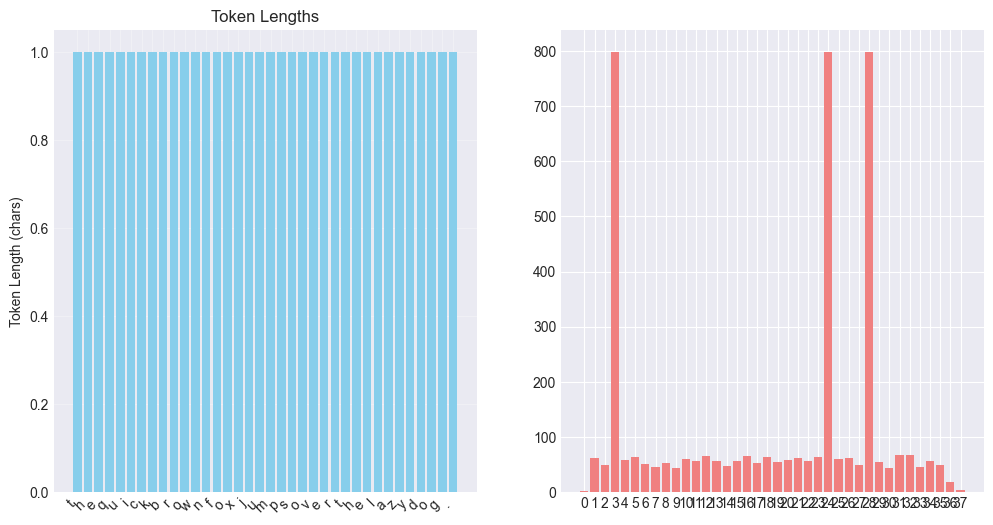

In [ ]:
# Load tokenizer
tokenizer = WordPieceTokenizer()
tokenizer.load_model('../tokenizer_8k.pkl')

# Example text
raw_text = "The quick brown fox jumps over the lazy dog."
print(f"Raw text: '{raw_text}'")
print(f"Length: {len(raw_text)} characters")

# Step 1: Tokenization
token_ids = tokenizer.encode(raw_text)
tokens = tokenizer.decode(token_ids).split()

print(f"\nAfter tokenization:")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of tokens: {len(token_ids)}")

# Visualize token mapping
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(tokens)), [len(token) for token in tokens], color='skyblue')
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.ylabel('Token Length (chars)')
plt.title('Token Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(len(token_ids)), token_ids, color='lightcoral')
plt.xticks(range(len(token_ids)), tokens, rotation=45, ha='right')
plt.ylabel('Token ID')
plt.title('Token IDs')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Special tokens
print(f"\nSpecial token IDs:")
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
for token in special_tokens:
    if token in tokenizer.vocab:
        print(f"  {token}: {tokenizer.vocab[token]}")

In [ ]:
# Create model
model = MiniBERT()

# Prepare input (add batch dimension)
input_ids = np.array([token_ids])  # Shape: [1, seq_len]
batch_size, seq_len = input_ids.shape

print(f"Input shape: {input_ids.shape}")
print(f"Batch size: {batch_size}, Sequence length: {seq_len}")

# Step 2a: Token embeddings lookup
token_embeddings = model.params['token_embeddings'][input_ids]  # [batch, seq_len, hidden_size]
print(f"\nToken embeddings shape: {token_embeddings.shape}")

# Step 2b: Position embeddings
position_embeddings = model.params['position_embeddings'][:seq_len]  # [seq_len, hidden_size]
print(f"Position embeddings shape: {position_embeddings.shape}")

# Step 2c: Combine embeddings
input_embeddings = token_embeddings + position_embeddings  # Broadcasting
print(f"Combined embeddings shape: {input_embeddings.shape}")

# Visualize embedding dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Token embeddings heatmap
im1 = axes[0].imshow(token_embeddings[0], cmap='RdBu_r', aspect='auto')
axes[0].set_title('Token Embeddings')
axes[0].set_xlabel('Hidden Dimension')
axes[0].set_ylabel('Token Position')
axes[0].set_yticks(range(len(tokens)))
axes[0].set_yticklabels([str(t)[:8] for t in tokens])
plt.colorbar(im1, ax=axes[0])

# Position embeddings heatmap
im2 = axes[1].imshow(position_embeddings, cmap='RdBu_r', aspect='auto')
axes[1].set_title('Position Embeddings')
axes[1].set_xlabel('Hidden Dimension')
axes[1].set_ylabel('Position')
plt.colorbar(im2, ax=axes[1])

# Combined embeddings heatmap
im3 = axes[2].imshow(input_embeddings[0], cmap='RdBu_r', aspect='auto')
axes[2].set_title('Combined Embeddings')
axes[2].set_xlabel('Hidden Dimension')
axes[2].set_ylabel('Token Position')
axes[2].set_yticks(range(len(tokens)))
axes[2].set_yticklabels([str(t)[:8] for t in tokens])
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nKey insight: Each token now has a {model.config.hidden_size}-dimensional vector")
print(f"that combines word meaning (token embedding) + position info")

## Part 3: Through the Transformer Layers

Now we trace how information flows through each transformer layer.

In [ ]:
def _resolve_num_layers(model):
    for attr in ("num_hidden_layers", "num_layers", "n_layers", "n_layer"):
        if hasattr(model.config, attr):
            return getattr(model.config, attr)
    if hasattr(model, "layers"):
        return len(model.layers)
    raise AttributeError("Cannot determine number of layers.")

def _get_param(model, name):
    if hasattr(model, name):
        return getattr(model, name)
    if hasattr(model, "params") and name in model.params:
        return model.params[name]
    raise AttributeError(f"Missing parameter '{name}'")

def _call_unwrap(fn, *args, **kwargs):
    """Call fn and always return (output, extras)."""
    out = fn(*args, **kwargs)
    if isinstance(out, tuple):
        return out[0], out[1:]   # first is tensor, rest are caches/stats
    return out, ()

def trace_through_layers(model, input_embeddings, detailed=True):
    """Trace input through each transformer layer."""
    layer_outputs = {'input': input_embeddings[0].copy()}
    current_hidden = input_embeddings

    print("Tracing through transformer layers...")
    print(f"Input shape: {current_hidden.shape}")

    num_layers = _resolve_num_layers(model)

    for layer_idx in range(num_layers):
        print(f"\n--- Layer {layer_idx} ---")
        layer_input = current_hidden.copy()

        # Multi-head attention
        print(f"  Input to attention: {current_hidden.shape}")
        attn_output, _ = _call_unwrap(model._multi_head_attention, current_hidden, layer_idx)
        print(f"  Attention output: {attn_output.shape}")

        # Residual + LN1 (post-norm)
        current_hidden = current_hidden + attn_output
        print(f"  After residual: {current_hidden.shape}")

        gamma = _get_param(model, f'ln1_gamma_{layer_idx}')
        beta  = _get_param(model, f'ln1_beta_{layer_idx}')
        current_hidden, _ = _call_unwrap(model._layer_norm, current_hidden, gamma, beta)
        print(f"  After layer norm 1: {current_hidden.shape}")

        # FFN
        ffn_input = current_hidden.copy()
        ffn_output, _ = _call_unwrap(model._feed_forward, current_hidden, layer_idx)
        print(f"  FFN output: {ffn_output.shape}")

        # Residual + LN2
        current_hidden = ffn_input + ffn_output
        print(f"  After residual: {current_hidden.shape}")

        gamma = _get_param(model, f'ln2_gamma_{layer_idx}')
        beta  = _get_param(model, f'ln2_beta_{layer_idx}')
        current_hidden, _ = _call_unwrap(model._layer_norm, current_hidden, gamma, beta)
        print(f"  Final output: {current_hidden.shape}")

        layer_outputs[f'layer_{layer_idx}'] = current_hidden[0].copy()

        if detailed:
            input_norm  = np.linalg.norm(layer_input[0])
            output_norm = np.linalg.norm(current_hidden[0])
            change_norm = np.linalg.norm(current_hidden[0] - layer_input[0])
            print(f"  Representation change: {change_norm:.4f} "
                  f"(input norm: {input_norm:.4f}, output norm: {output_norm:.4f})")

    return layer_outputs, current_hidden

# Trace through layers
layer_outputs, final_hidden = trace_through_layers(model, input_embeddings)

print(f"\nFinal hidden states shape: {final_hidden.shape}")
print(f"Each token now has a context-aware representation!")

### Visualizing Layer-by-Layer Changes

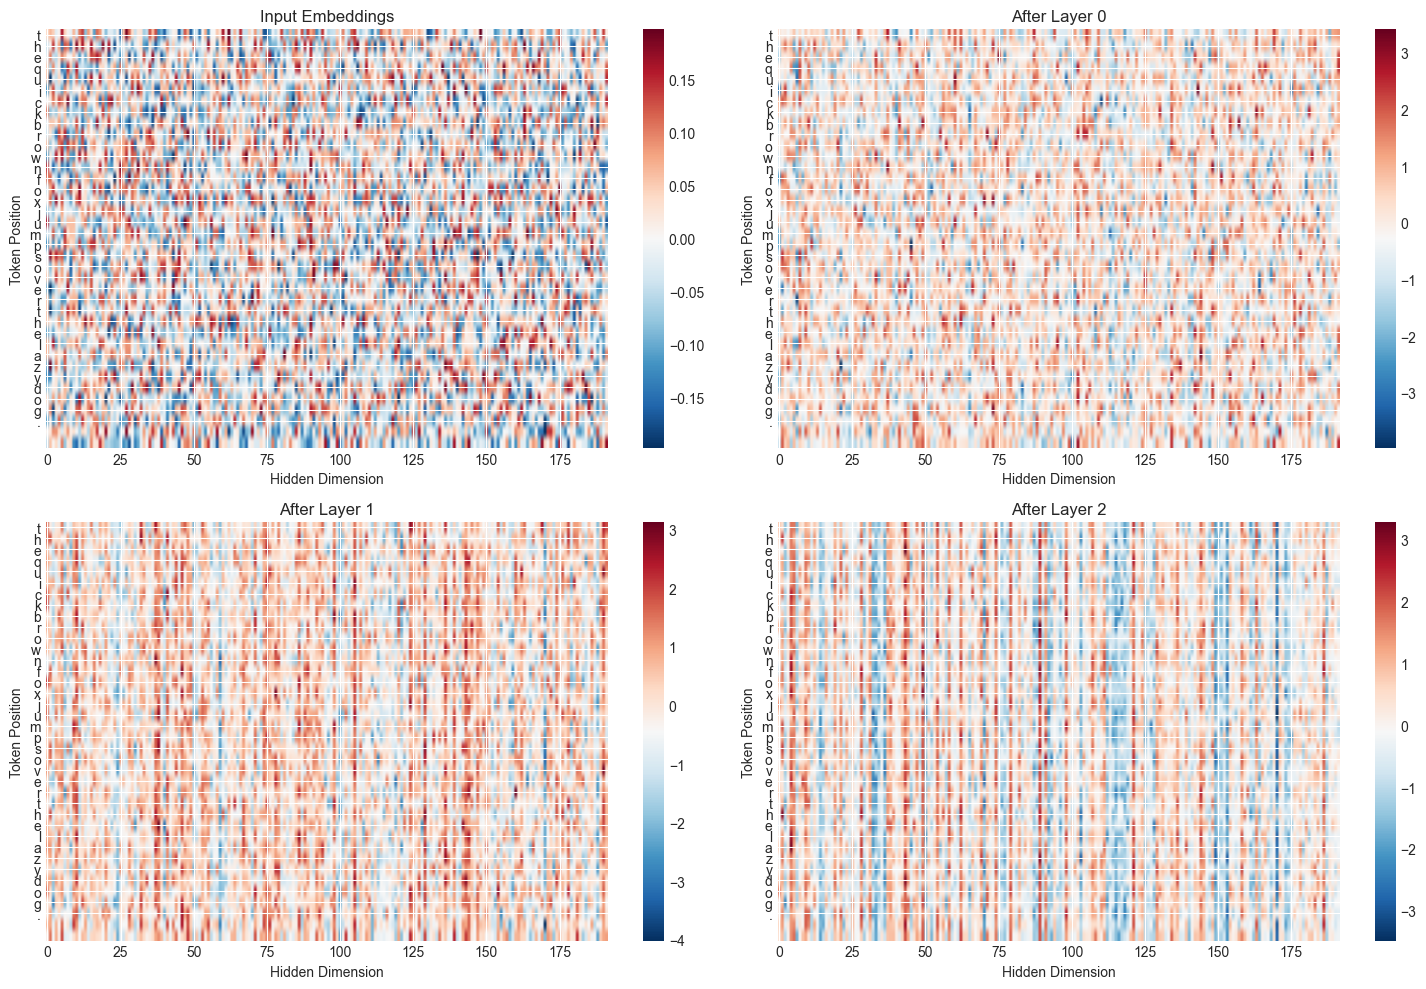


Layer-to-layer similarity (cosine similarity):
  input â†’ layer_0: 0.5629
  layer_0 â†’ layer_1: 0.5099
  layer_1 â†’ layer_2: 0.4019


In [14]:
# Visualize how representations evolve through layers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot representations at different layers
layers_to_show = ['input', 'layer_0', 'layer_1', 'layer_2']
titles = ['Input Embeddings', 'After Layer 0', 'After Layer 1', 'After Layer 2']

for idx, (layer_name, title) in enumerate(zip(layers_to_show, titles)):
    if layer_name in layer_outputs:
        representation = layer_outputs[layer_name]
        
        im = axes[idx].imshow(representation, cmap='RdBu_r', aspect='auto')
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Hidden Dimension')
        axes[idx].set_ylabel('Token Position')
        axes[idx].set_yticks(range(len(tokens)))
        axes[idx].set_yticklabels(tokens)
        plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

# Analyze representation similarity between layers
print("\nLayer-to-layer similarity (cosine similarity):")
for i in range(len(layers_to_show) - 1):
    layer1 = layers_to_show[i]
    layer2 = layers_to_show[i + 1]
    
    if layer1 in layer_outputs and layer2 in layer_outputs:
        repr1 = layer_outputs[layer1].flatten()
        repr2 = layer_outputs[layer2].flatten()
        
        # Cosine similarity
        similarity = np.dot(repr1, repr2) / (np.linalg.norm(repr1) * np.linalg.norm(repr2))
        print(f"  {layer1} â†’ {layer2}: {similarity:.4f}")

## Part 4: From Hidden States to Logits

The final hidden states are projected to vocabulary-sized logits.

After final layer norm: (1, 38, 192)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
# --- Resolve / create MLM head (safe: no `or` on arrays) ---
def _first_available(names):
    for n in names:
        v = _get_param(n)
        if v is not None:
            return v, n
    return None, None

emb, emb_name = _first_available([
    "token_embedding", "token_embeddings",
    "word_embeddings", "embeddings", "embedding"
])

W = getattr(model, "mlm_head_weight", None)
b = getattr(model, "mlm_head_bias",  None)

# Create or tie the MLM head weight
if W is None:
    if emb is not None:
        if emb.ndim != 2:
            raise ValueError(f"{emb_name} must be 2D (vocab_size, hidden_size), got {emb.shape}")
        vocab_size, emb_dim = emb.shape
        if emb_dim == hidden_size:
            W = emb.T.copy()  # (H, V)
        elif vocab_size == hidden_size:
            W = emb.copy()    # already (H, V)
        else:
            raise ValueError(f"Embedding shape {emb.shape} incompatible with hidden_size={hidden_size}")
        print(f"MLM head weight tied to {emb_name}.")
    else:
        # Fallback: init untied MLM head
        if hasattr(model, "config") and hasattr(model.config, "vocab_size"):
            vocab_size = model.config.vocab_size
        elif hasattr(tokenizer, "vocab_size"):
            vocab_size = tokenizer.vocab_size
        elif hasattr(tokenizer, "vocab"):
            vocab_size = len(tokenizer.vocab)
        else:
            raise ValueError("Cannot determine vocab_size for MLM head.")
        rng = np.random.default_rng(123)
        W = rng.normal(0.0, 0.02, size=(hidden_size, vocab_size)).astype(dtype)
        print("MLM head weight initialized (untied).")
    setattr(model, "mlm_head_weight", W)

# Bias
if b is None:
    b = np.zeros(model.mlm_head_weight.shape[1], dtype=dtype)
    setattr(model, "mlm_head_bias", b)

# Ensure orientation (H, V)
W = model.mlm_head_weight
if W.shape[0] != hidden_size and W.shape[1] == hidden_size:
    W = W.T
    model.mlm_head_weight = W
assert W.shape[0] == hidden_size, f"MLM weight shape {W.shape} != ({hidden_size}, vocab_size)"


In [28]:
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Convert logits to probabilities
probabilities = softmax(logits, axis=-1)  # [B, S, V]
print(f"Probabilities shape: {probabilities.shape}")
print(f"Probabilities sum to 1: {probabilities[0, 0].sum():.6f}")

# Ensure seq_len matches token_ids length
seq_len = logits.shape[1]
token_ids = np.asarray(token_ids).reshape(-1)
if len(token_ids) != seq_len:
    raise ValueError(f"seq_len ({seq_len}) != len(token_ids) ({len(token_ids)}). "
                     "Use the exact input_ids fed to the model.")

# Helper to turn ids into readable tokens without merging subwords
def id_to_str(idx: int) -> str:
    idx = int(idx)
    if hasattr(tokenizer, 'id_to_token') and isinstance(tokenizer.id_to_token, dict):
        return tokenizer.id_to_token.get(idx, f'ID_{idx}')
    if hasattr(tokenizer, 'convert_ids_to_tokens'):
        return tokenizer.convert_ids_to_tokens([idx])[0]
    if hasattr(tokenizer, 'vocab'):
        # invert vocab once
        if not hasattr(tokenizer, '_inv_vocab'):
            tokenizer._inv_vocab = {v: k for k, v in tokenizer.vocab.items()}
        return tokenizer._inv_vocab.get(idx, f'ID_{idx}')
    return f'ID_{idx}'

# Aligned per-position input tokens/ids
input_ids_per_pos = [int(i) for i in token_ids]
input_tokens_per_pos = [id_to_str(i) for i in input_ids_per_pos]

# Get top predictions for each position
top_k = 5
top_predictions = []
for pos in range(seq_len):
    pos_probs = probabilities[0, pos]                 # (V,)
    top_indices = np.argsort(pos_probs)[-top_k:][::-1]
    top_probs   = pos_probs[top_indices]
    top_tokens  = [id_to_str(i) for i in top_indices]

    top_predictions.append({
        'position': pos,
        'input_id': input_ids_per_pos[pos],
        'input_token': input_tokens_per_pos[pos],
        'predictions': list(zip(top_tokens, top_probs, top_indices))
    })

# Display predictions
print("\nTop predictions for each position:")
print("=" * 60)
for pred_info in top_predictions[:5]:  # Show first 5 positions
    pos = pred_info['position']
    input_token = pred_info['input_token']
    input_id = pred_info['input_id']
    print(f"\nPosition {pos}: Input token = '{input_token}' (ID: {input_id})")
    print("Top predictions:")
    for rank, (pred_token, prob, token_id) in enumerate(pred_info['predictions']):
        is_correct = int(token_id) == int(input_id)   # compare by ID
        marker = " [✓]" if is_correct else ""
        print(f"  {rank+1}. '{pred_token}' (ID: {int(token_id)}) - {prob*100:.2f}%{marker}")


Probabilities shape: (1, 38, 8192)
Probabilities sum to 1: 1.000000

Top predictions for each position:

Position 0: Input token = '[CLS]' (ID: 2)
Top predictions:
  1. 'ID_1402' (ID: 1402) - 0.18%
  2. 'ID_2018' (ID: 2018) - 0.14%
  3. 'ID_5373' (ID: 5373) - 0.11%
  4. 'ID_4041' (ID: 4041) - 0.11%
  5. 'è' (ID: 101) - 0.10%

Position 1: Input token = 't' (ID: 62)
Top predictions:
  1. 'ID_2018' (ID: 2018) - 0.13%
  2. 'ID_4718' (ID: 4718) - 0.13%
  3. 'ID_1859' (ID: 1859) - 0.12%
  4. 'ช' (ID: 422) - 0.12%
  5. 'ID_5883' (ID: 5883) - 0.12%

Position 2: Input token = 'h' (ID: 50)
Top predictions:
  1. 'ID_2819' (ID: 2819) - 0.12%
  2. 'ID_1402' (ID: 1402) - 0.11%
  3. 'ID_6692' (ID: 6692) - 0.10%
  4. 'ID_7457' (ID: 7457) - 0.09%
  5. 'ID_5043' (ID: 5043) - 0.09%

Position 3: Input token = 'e' (ID: 798)
Top predictions:
  1. 'ID_1402' (ID: 1402) - 0.13%
  2. 'ID_4718' (ID: 4718) - 0.12%
  3. 'ID_8020' (ID: 8020) - 0.12%
  4. 'ID_5373' (ID: 5373) - 0.12%
  5. 'ID_4328' (ID: 4328) - 0.11

In [ ]:
# Apply final layer norm to the output from transformers
final_layer_norm = final_hidden

# Get model configuration
hidden_size = final_layer_norm.shape[-1]
dtype = final_layer_norm.dtype

# Create final layer norm parameters if they don't exist
if not hasattr(model, 'final_ln_gamma'):
    model.final_ln_gamma = np.ones(hidden_size, dtype=dtype)
if not hasattr(model, 'final_ln_beta'):
    model.final_ln_beta = np.zeros(hidden_size, dtype=dtype)

# Apply layer normalization
final_layer_norm, _ = model._layer_norm(final_hidden, model.final_ln_gamma, model.final_ln_beta)

print(f"After final layer norm: {final_layer_norm.shape}")

In [ ]:
# Create MLM head weight if it doesn't exist
vocab_size = len(tokenizer.vocab) if hasattr(tokenizer, 'vocab') else 8192
hidden_size = final_layer_norm.shape[-1]

if not hasattr(model, 'mlm_head_weight'):
    # Use token embeddings for weight tying
    if hasattr(model, 'params') and 'token_embeddings' in model.params:
        emb = model.params['token_embeddings']
        if emb.shape == (vocab_size, hidden_size):
            W = emb.T.copy()  # (H, V)
        else:
            W = emb.copy()    # assume already (H, V)
        model.mlm_head_weight = W
        print("MLM head weight tied to token embeddings.")
    else:
        # Initialize random weights
        np.random.seed(42)
        W = np.random.normal(0.0, 0.02, size=(hidden_size, vocab_size)).astype(dtype)
        model.mlm_head_weight = W
        print("MLM head weight initialized randomly.")

if not hasattr(model, 'mlm_head_bias'):
    model.mlm_head_bias = np.zeros(vocab_size, dtype=dtype)

# Compute logits: (B, S, H) @ (H, V) -> (B, S, V)
logits = final_layer_norm @ model.mlm_head_weight + model.mlm_head_bias

print(f"Logits shape: {logits.shape}")
print(f"MLM head weight shape: {model.mlm_head_weight.shape}")
print(f"MLM head bias shape: {model.mlm_head_bias.shape}")

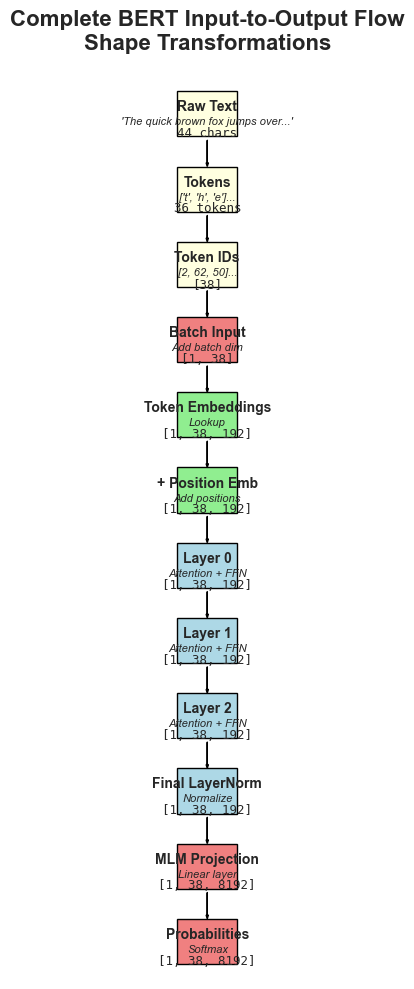


SHAPE TRANSFORMATION SUMMARY
Stage                Input Shape     Output Shape    Key Operation            
--------------------------------------------------------------------------------
Tokenization         Text            [38]            String â†’ Token IDs     
Batching             [38]            [1,38]          Add batch dimension      
Token Embedding      [1,38]          [1,38,192]      ID â†’ Dense vector      
Position Embedding   [1,38,192]      [1,38,192]      Add position info        
Transformer x3       [1,38,192]      [1,38,192]      Self-attention + FFN     
MLM Head             [1,38,192]      [1,38,8192]     Project to vocab         
Softmax              [1,38,8192]     [1,38,8192]     Logits â†’ Probabilities 

Key Insights:
â€¢ Hidden dimension (192) stays constant through transformer layers
â€¢ Only the final projection changes the last dimension
â€¢ Batch and sequence dimensions are preserved throughout
â€¢ Each position gets independent predictions


In [34]:
def create_shape_flow_diagram():
    """Create a visual summary of shape transformations."""
    
    # Define the pipeline stages
    stages = [
        ("Raw Text", f"'{raw_text[:30]}...'", f"{len(raw_text)} chars"),
        ("Tokens", f"{tokens[:3]}...", f"{len(tokens)} tokens"),
        ("Token IDs", f"{token_ids[:3]}...", f"[{seq_len}]"),
        ("Batch Input", "Add batch dim", f"[1, {seq_len}]"),
        ("Token Embeddings", "Lookup", f"[1, {seq_len}, 192]"),
        ("+ Position Emb", "Add positions", f"[1, {seq_len}, 192]"),
        ("Layer 0", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Layer 1", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Layer 2", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Final LayerNorm", "Normalize", f"[1, {seq_len}, 192]"),
        ("MLM Projection", "Linear layer", f"[1, {seq_len}, 8192]"),
        ("Probabilities", "Softmax", f"[1, {seq_len}, 8192]")
    ]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Position stages
    y_positions = range(len(stages))
    x_center = 0.5
    
    # Draw boxes and connections
    for i, (stage_name, operation, shape) in enumerate(stages):
        y = len(stages) - 1 - i  # Reverse order (top to bottom)
        
        # Draw box
        box_width = 0.8
        box_height = 0.6
        
        # Color coding
        if 'Layer' in stage_name:
            color = 'lightblue'
        elif 'Embedding' in stage_name or 'Position' in stage_name:
            color = 'lightgreen'
        elif stage_name in ['Raw Text', 'Tokens', 'Token IDs']:
            color = 'lightyellow'
        else:
            color = 'lightcoral'
        
        # Draw rectangle
        rect = plt.Rectangle((x_center - box_width/2, y - box_height/2), 
                           box_width, box_height, 
                           facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_center, y + 0.1, stage_name, ha='center', va='center', 
                fontweight='bold', fontsize=10)
        ax.text(x_center, y - 0.1, operation, ha='center', va='center', 
                fontsize=8, style='italic')
        ax.text(x_center, y - 0.25, shape, ha='center', va='center', 
                fontsize=9, fontfamily='monospace')
        
        # Draw arrow to next stage
        if i < len(stages) - 1:
            ax.arrow(x_center, y - box_height/2 - 0.05, 0, -0.3, 
                    head_width=0.03, head_length=0.05, fc='black', ec='black')
    
    # Set limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(stages) - 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('Complete BERT Input-to-Output Flow\nShape Transformations', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Create the diagram
create_shape_flow_diagram()

# Print summary table
print("\n" + "="*80)
print("SHAPE TRANSFORMATION SUMMARY")
print("="*80)
print(f"{'Stage':<20} {'Input Shape':<15} {'Output Shape':<15} {'Key Operation':<25}")
print("-" * 80)

transformations = [
    ('Tokenization', 'Text', f'[{seq_len}]', 'String â†’ Token IDs'),
    ('Batching', f'[{seq_len}]', f'[1,{seq_len}]', 'Add batch dimension'),
    ('Token Embedding', f'[1,{seq_len}]', f'[1,{seq_len},192]', 'ID â†’ Dense vector'),
    ('Position Embedding', f'[1,{seq_len},192]', f'[1,{seq_len},192]', 'Add position info'),
    ('Transformer x3', f'[1,{seq_len},192]', f'[1,{seq_len},192]', 'Self-attention + FFN'),
    ('MLM Head', f'[1,{seq_len},192]', f'[1,{seq_len},8192]', 'Project to vocab'),
    ('Softmax', f'[1,{seq_len},8192]', f'[1,{seq_len},8192]', 'Logits â†’ Probabilities')
]

for stage, input_shape, output_shape, operation in transformations:
    print(f"{stage:<20} {input_shape:<15} {output_shape:<15} {operation:<25}")

print("\nKey Insights:")
print("â€¢ Hidden dimension (192) stays constant through transformer layers")
print("â€¢ Only the final projection changes the last dimension")
print("â€¢ Batch and sequence dimensions are preserved throughout")
print("â€¢ Each position gets independent predictions")

In [ ]:
# =========================
# Masked-LM probe (end-to-end)
# =========================
import numpy as np

# ---------- Helpers ----------
def softmax(x, axis=-1):
    x = np.asarray(x)
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def unwrap_out(out):
    """Return first element if function returns a tuple; else return the object itself."""
    return out[0] if isinstance(out, tuple) else out

def id_to_str(tokenizer, idx: int) -> str:
    """Turn a single id into a readable token string without merging subwords."""
    idx = int(idx)
    if hasattr(tokenizer, 'vocab'):
        # Build inverse vocab once
        if not hasattr(tokenizer, '_inv_vocab'):
            tokenizer._inv_vocab = {v: k for k, v in tokenizer.vocab.items()}
        return tokenizer._inv_vocab.get(idx, f'ID_{idx}')
    return f'ID_{idx}'

# ---------- 0) Prepare input ----------
# Use the same raw text as before
print("Original text:", raw_text)
print("Original tokens (aligned to IDs):", tokens)

# ---------- 1) Build masked input ----------
# Ensure config.vocab_size is correct
vocab_size = len(tokenizer.vocab)

# Determine [MASK] id and sanity-check
if '[MASK]' in tokenizer.vocab:
    mask_id = tokenizer.vocab['[MASK]']
else:
    raise ValueError("Tokenizer missing '[MASK]' token in vocab.")

# mask_tokens signature: (ids, vocab_size, mask_id, p_mask)
ids_2d = np.array([token_ids], dtype=np.int64)  # [B, S]
masked_ids, target_ids, mask_positions = mask_tokens(
    ids_2d,
    vocab_size=vocab_size,
    mask_id=mask_id,
    p_mask=0.15
)

# Show masked text 
masked_tokens = [id_to_str(tokenizer, i) for i in masked_ids[0]]
print("\\nMasked tokens:", masked_tokens)

# ---------- 2) Forward pass ----------
# Your model.forward may return (logits, cache) or just logits
forward_out = model.forward(masked_ids)
masked_logits = unwrap_out(forward_out)           # [B, S, V]
masked_probabilities = softmax(masked_logits, axis=-1)

print("\\nMasked input forward pass:")
print(f"Input shape:  {masked_ids.shape}")
print(f"Logits shape: {masked_logits.shape}")

# ---------- 3) Collect masked positions & true ids ----------
positions = []
truth_ids = []

if isinstance(target_ids, np.ndarray) and target_ids.shape == masked_ids.shape:
    # full matrix with sentinel
    sentinel = -100
    pos_arr = np.where(target_ids[0] != sentinel)[0]
    positions = [int(p) for p in pos_arr]
    truth_ids = [int(target_ids[0, p]) for p in pos_arr]
else:
    # assume lists aligned with mask_positions
    positions = list(map(int, mask_positions[0])) if len(mask_positions) > 0 else []
    truth_ids = [int(t) for t in (target_ids[0] if len(target_ids) > 0 else [])]
    if len(truth_ids) != len(positions):
        # best-effort alignment if lengths disagree
        n = min(len(truth_ids), len(positions))
        positions, truth_ids = positions[:n], truth_ids[:n]

# ---------- 4) Report top-k at masked positions ----------
top_k = 5
print("\\nPredictions for masked positions:")
print("=" * 60)

if not positions:
    print("No tokens were masked in this example. Re-run or increase p_mask.")
else:
    for pos, true_id in zip(positions, truth_ids):
        pos_probs = masked_probabilities[0, pos]            # (V,)
        top_idx = np.argsort(pos_probs)[-top_k:][::-1]
        top_probs = pos_probs[top_idx]
        top_toks = [id_to_str(tokenizer, i) for i in top_idx]

        true_tok = id_to_str(tokenizer, true_id)
        true_p = float(pos_probs[true_id])
        rank = int(np.sum(pos_probs > true_p) + 1)

        print(f"\\nPosition {pos}: input token='{masked_tokens[pos]}', true='{true_tok}' (ID {true_id})")
        for r, (pid, p, ptok) in enumerate(zip(top_idx, top_probs, top_toks), 1):
            marker = " [✓]" if int(pid) == int(true_id) else ""
            print(f"  {r}. '{ptok}' (ID {int(pid)}) - {p*100:.2f}%{marker}")
        print(f"  True token probability: {true_p*100:.2f}% (rank {rank})")

## Summary: Complete Journey

### **The Complete Pipeline**
1. **Text â†’ Tokens**: "Hello world" â†’ ["Hello", "world"]
2. **Tokens â†’ IDs**: ["Hello", "world"] â†’ [1234, 5678]
3. **IDs â†’ Embeddings**: [1234, 5678] â†’ Dense vectors
4. **Through Transformers**: Context-aware representations
5. **To Vocabulary**: Project back to vocabulary space
6. **To Predictions**: Softmax â†’ Probabilities

### **Key Shape Transformations**
- **[text] â†’ [seq_len] â†’ [1, seq_len] â†’ [1, seq_len, 192] â†’ [1, seq_len, 8192]**

### **What Each Component Does**
- **Embeddings**: Convert discrete â†’ continuous
- **Transformers**: Add context awareness
- **Output projection**: Map back to vocabulary
- **Softmax**: Convert to probabilities

### **Why This Design Works**
- **Constant hidden size**: Allows deep stacking
- **Residual connections**: Enable gradient flow
- **Attention**: Captures long-range dependencies
- **Position embeddings**: Preserve order information

## Exercises

1. **Different Texts**: Try the pipeline with different input texts. How do the representations change?

2. **Layer Analysis**: Compare representations at different layers. Which layers capture which types of information?

3. **Attention Patterns**: Extract and visualize attention weights. What patterns do you see?

4. **Vocabulary Analysis**: Which tokens does the model predict most confidently? Why?

In [ ]:
# Space for your experiments
# Try different texts here:
# different_text = "Your text here"
